# Testing the DEWFluid 'coder' module

In [38]:
import numpy as np
from thermoengine import phases
from thermoengine import model
import pyQ3
import dill
#%run core.ipynb
import importlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Create the DEWFluid phase object
This imports the manually created coder python module. This is not a coder produced module, but ENKI will treat it as though it is.

In [3]:
DEWFluid = phases.SolutionPhase('DEWFluid_', 'DEW', calib=False, source='coder',coder_module='DEWFluid_module')

Module generated by the coder package does not yet provide a formula method.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.


The system properties are currently hard-coded into the module, the system is set up with the elements:

In [4]:
elements = ['O', 'H', 'Si']#, 'Na', 'Cl']
basis_species = ['H2O', 'H+', 'O2(G)', 'H4SIO4(AQ)']#, 'NA+', 'CL-']
other_species = ['H6SI2O7(AQ)', 'H8SI3O10(AQ)', 'H3SIO4-', 'OH-', 'O2(AQ)']#, 'NACL(AQ)']
# elements = pyQ3.defaultsystem.elements
# basis_species = pyQ3.defaultsystem.basis_species_names
# other_species = pyQ3.defaultsystem.other_species_names
sys = pyQ3.System(elements=elements, basis_species=basis_species, other_species=other_species)
sys.elements

['O', 'H', 'Si']

Demo call to the gibbs_energy function. Note that the code cannot deal correctly with O. It will map any O that isn't accounted for in other basis species into O2 molecules. This then leaves a net positive charge, which is offset by calculating a negative H+ molality. When EQ3 is called, redox equilibria are set by an imposed fO2, and H+ by charge balance, and so the code still runs.

In [5]:
moles = np.array([0.3 + 0.04, 
                  0.6 + 0.04, 
                  0.01,
#                   0.0,
#                   0.0
                 ])

# moles = np.array([0.5+0.04,
#                   1.0+0.04,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.01,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0,
#                   0.0])

moles = moles/np.sum(moles)
moles

array([0.34343434, 0.64646465, 0.01010101])

In [6]:
DEWFluid.gibbs_energy(573,10000,mol=moles)

-29637.991116535588

In [7]:
output = pyQ3.output.eq3output('eq_working/output')

# Testing the free energy
Hopefully the calculation is sufficiently precise that we can generate smooth values of the free energy. Here I demonstrate the variation of the solution free energy as salinity is increased.

In [7]:
NaCl_fractions = np.logspace(-4,-0.5,10)
SiO2 = 0.01

mol_fractions = list()

for i in range(np.shape(NaCl_fractions)[0]):
    mols = np.zeros(len(elements))
    mols[0] = 2/3*(1 + 4*SiO2)
    mols[1] = 1/3*(1 + 4*SiO2)
    mols[2] = SiO2
    mols[3] = NaCl_fractions[i]
    mols[4] = NaCl_fractions[i]
    mols = mols/np.sum(mols)
    mol_fractions.append(mols)

free_energies = []

for i in range(np.shape(NaCl_fractions)[0]):
    free_energies.append(DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i]))



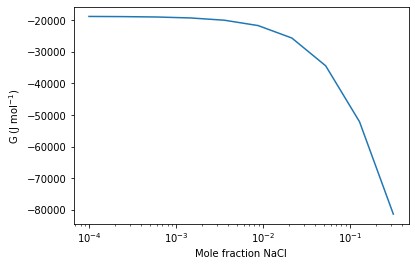

In [8]:
f,a = plt.subplots()
a.plot(NaCl_fractions,free_energies)
a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-1}$)')
a.set_xlabel('Mole fraction NaCl')
plt.show()

## Testing the first derivative
Testing the derivative is slightly less straightforward. Ideally we want to be able to plot a free energy curve as a reference point for the general behaviour of the derivative, in addition to checking the derivative is smooth. Smoothness is important as this will be controlled by the precision of the calculation and the precision of the output file. The derivatives are controlled by variations in a single component, e.g. Cl.


In [8]:
# Si_fractions = np.linspace(0.0001,0.1,20)

Si_fractions= [0.01]

mol_fractions = list()

for i in range(np.shape(Si_fractions)[0]):
    mols = np.zeros(len(elements))
    mols[0] = 6 + Si_fractions[i]*4
    mols[1] = 3 + Si_fractions[i]*4
    mols[2] = Si_fractions[i]
    mols = mols/np.sum(mols)
    mol_fractions.append(mols)

free_energies = []
dgdn = np.zeros([np.shape(Si_fractions)[0],len(elements)])
d2gdn2 = np.zeros([np.shape(Si_fractions)[0],len(elements),len(elements)])
# dgdSi = list()

for i in range(np.shape(Si_fractions)[0]):
    print(i)
    try:
        free_energies.append(DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i]))
    except:
        free_energies.append(np.nan)
    try:
        dgdn[i,:] = DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i],deriv={'dmol':1})
    except:
        dgdn[i,:] = [np.nan]*np.shape(dgdn)[1]
    try:
        d2gdn2[i,:,:] = DEWFluid.gibbs_energy(573,10000,mol=mol_fractions[i],deriv={'dmol':2})
    except:
        pass
        #     if i >0:
#         dgdSi.append((free_energies[i]-free_energies[i-1])/(Si_fractions[i]-Si_fractions[i-1]))


0


In [10]:
d2gdn2

array([[[ 0.00000000e+00, -1.58794831e+09,  0.00000000e+00],
        [-1.58794831e+09, -2.43800326e+09,  2.42536026e-01],
        [ 0.00000000e+00,  2.42536026e-01, -2.11475128e+09]]])

In [11]:
DEWFluid.gibbs_energy(573,10000, mol=mol_fractions[0], deriv={'dmol':3})

array([[[[ 0.00000000e+00,  1.68716800e+14,  8.12434830e+14],
         [ 2.08627384e+14,  2.08627384e+14, -7.96024047e+14],
         [ 0.00000000e+00,  3.52090914e+04,  0.00000000e+00]],

        [[ 2.08627384e+14,  2.08627384e+14, -4.40183997e+13],
         [ 1.68716800e+14,  5.96297095e+14, -5.84966854e+13],
         [-6.71670657e+02, -4.50184777e+04, -4.50184777e+04]],

        [[ 0.00000000e+00,  2.08627384e+14,  0.00000000e+00],
         [ 1.54451164e+04, -4.50184777e+04, -4.50184777e+04],
         [ 8.12434830e+14, -5.84966854e+13,  2.06429887e+14]]]])

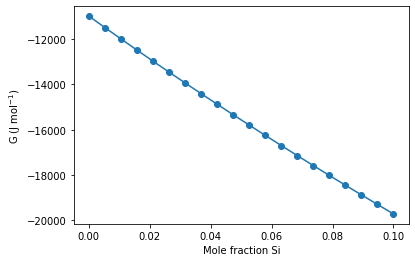

In [10]:
f,a = plt.subplots()
a.plot(Si_fractions,free_energies, marker='o')
# a.set_xscale('log')
a.set_ylabel(r'G (J mol$^{-1}$)')
a.set_xlabel('Mole fraction Si')
plt.show()

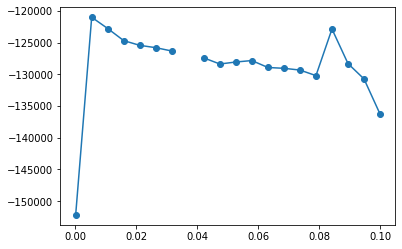

In [19]:
f,a = plt.subplots()
# for i in range(len(elements)):
#     a.plot(Si_fractions,dgdn[:,i],label=elements[i])
a.plot(Si_fractions,dgdn[:,3], marker='o')
# a.plot(Si_fractions[1:],dgdSi,ls='--')
# a.set_xscale('log')
# a.legend()
plt.show()

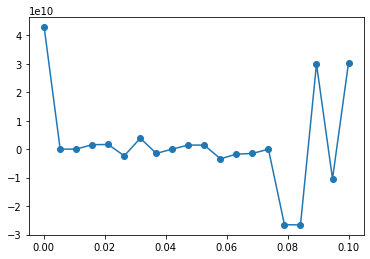

In [27]:
f,a = plt.subplots()
# for i in range(len(elements)):
#     a.plot(Si_fractions,dgdn[:,i],label=elements[i])
a.plot(Si_fractions,d2gdn2[:,3,4], marker='o')
# a.plot(Si_fractions,-d2gdn2[:,2,2])
# a.plot(Si_fractions[1:],dgdSi,ls='--')
# a.set_xscale('log')
# a.set_yscale('log')
# a.legend()
plt.show()

## Test in the Equilibrate algorithm

In [12]:
from thermoengine import core, equilibrate

In [13]:
elm_sys = ['O', 'H', 'Si']
elm_sys

['O', 'H', 'Si']

In [14]:
phs_sys = [DEWFluid]

In [15]:
mol_elm = [2.04, 1.04, 0.01]
# mol_elm = [1.4, 2.4, 0.1, 0.01, 0.01]
mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([0.66019417, 0.33656958, 0.00323625])

In [16]:
blk_cmp = mol_elm

### Simple Equilibrate run- no fO2 constraint- only DEW

In [17]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys)

In [18]:
t = 723.15
p = 10000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

DEW is the omnicomponent phase.
Stable phase assemblage computed. Exiting.
 
T =     450.00 °C, P =     1000.0 MPa
DEW             moles:   1.000000 grams:   6.141
              O form:  O              X:  0.3366  wt%    SiO2    3.17
              H form:  H              X:  0.6602  wt%     H2O   96.83
             Si form:  Si             X:  0.0032  


In [19]:
state.dGdn()

array([[ -40763.14504688],
       [      0.        ],
       [-893139.1857001 ]])

### Add in fO2 constraint

In [20]:
def muO2_std(t, p):
        tr = 298.15
        hs = 23.10248*(t-tr) + 2.0*804.8876*(np.sqrt(t)-np.sqrt(tr)) - 1762835.0*(1.0/t-1.0/tr) \
           - 18172.91960*np.log(t/tr) + 0.5*0.002676*(t*t-tr*tr)
        ss = 205.15 + 23.10248*np.log(t/tr)  - 2.0*804.8876*(1.0/np.sqrt(t)-1.0/np.sqrt(tr)) \
           - 0.5*1762835.0*(1.0/(t*t)-1.0/(tr*tr)) + 18172.91960*(1.0/t-1.0/tr) + 0.002676*(t-tr)
        return hs - t*ss + 205.15*298.15

def muO2(t, p, state):
    std = muO2_std(t, p)
    mu = std + 8.314*t*np.log(10**-12.0)
    return mu

In [21]:
muO2(100.0, 1000.0, None)

14529.923494307459

In [22]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys, lagrange_l=[({'O':2.0},muO2)]) 

In [23]:
t = 723.15
p = 10000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

CTf (1, 3)
[[2. 0. 0.]]
A_omni_inv (3, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
U (3, 3)
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
S (3,)
[2. 0. 0.]
VT (3, 3)
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1.  0.  0.]]
VT null space (2, 3)
[[ 0.  0.  1.]
 [-1.  0.  0.]]
DEW is the omnicomponent phase.
Zero element projection matrix (3, 3)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
A before projection and augmentation (3, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
A after projection and before augmentation (3, 3)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
A reaction matrix (3, 3)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
.....
Enforcing chemical potential constraints.
Maximum linear step search length;  0.5
Minimum linear step search length;  -0.32805000000000006
 
 Func-count     x          f(x)          Procedure
    1      -0.011763       190491        initial
    2       0.183713       186005        golden
    3       0.304524       189960        golden
    4       0.151148       185545        parabolic
    5       0.1091

In [43]:
output = pyQ3.output.eq3output('eq_working/output')
output = output.elemental_comp.set_index('element')
molality = pd.to_numeric(output.molality)

In [44]:
molality/molality.sum()

element
O     0.342354
H     0.648626
SI    0.009020
Name: molality, dtype: float64

### Try simple calculation with quartz

In [16]:
berman = model.Database()

In [17]:
qz = berman.get_phase('Qz')
coe = berman.get_phase('Coe')

In [18]:
qz.enable_gibbs_energy_reference_state()
coe.enable_gibbs_energy_reference_state()

In [19]:
mol_elm = [2.04, 1.04, 0.01]
# mol_elm = [1.4, 2.4, 0.1, 0.01, 0.01]
mol_elm = mol_elm/np.sum(mol_elm)
mol_elm

array([0.66019417, 0.33656958, 0.00323625])

In [20]:
blk_cmp = mol_elm

In [21]:
phs_sys = [DEWFluid, qz, coe]

In [22]:
equil = equilibrate.Equilibrate(elm_sys, phs_sys)

In [ ]:
t = 723.15
p = 1000.0
state = equil.execute(t, p, bulk_comp=blk_cmp, debug=3, stats=True)
state.print_state()

In [53]:
DEWFluid.test_endmember_comp(mol_elm)

False

In [54]:
np.sum(mol_elm)

1.0000000000000002